In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats

In [2]:
crashfp ='/Users/jacksonpeoples/Desktop/Springboard/CapstoneTwo/Data/crash_cleaned.csv'
hourlyfp ='/Users/jacksonpeoples/Desktop/Springboard/CapstoneTwo/Data/hourly_crash_cleaned.csv'
crash = pd.read_csv(crashfp)
hourly = pd.read_csv(hourlyfp)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161819 entries, 0 to 161818
Data columns (total 60 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   crash_id                            161819 non-null  int64  
 1   crash_fatal_fl                      161819 non-null  object 
 2   crash_date                          161819 non-null  object 
 3   crash_time                          161819 non-null  object 
 4   rpt_block_num                       140411 non-null  object 
 5   rpt_street_pfx                      90518 non-null   object 
 6   rpt_street_name                     161818 non-null  object 
 7   rpt_street_sfx                      118702 non-null  object 
 8   crash_speed_limit                   161819 non-null  float64
 9   road_constr_zone_fl                 161819 non-null  object 
 10  latitude                            155987 non-null  float64
 11  longitude                 

In [4]:
crash['street_name'].value_counts(normalize=True).head(15)

IH0035            0.158739
US0183            0.066791
SL0001            0.050544
US0290            0.031270
SH0071            0.021302
FM0734            0.017211
SL0343            0.015975
SL0360            0.014770
SL0275            0.014720
S 1ST ST          0.014108
N LAMAR BLVD      0.013731
E RIVERSIDE DR    0.013589
W SLAUGHTER LN    0.012007
RM2222            0.010295
S CONGRESS AVE    0.009764
Name: street_name, dtype: float64

While there is a lot of interesting data in this set, much of it tells me little to nothing about the relative danger of getting in my car and driving right now. It's interesting to see where the most crashes happen, but if I don't know
what proportion of Austin traffic is where, it tells me little about the relative risk of driving at any given place.

Since I'd like to develop an algorithm that predicts the amount of crashes that will occur in Austin in a given hour,
the dataframe that matches that granularity will be much more helpful.

In [5]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93503 entries, 0 to 93502
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   utc_unix    93503 non-null  int64  
 1   dt_iso      93503 non-null  object 
 2   timezone    93503 non-null  int64  
 3   city_name   93503 non-null  object 
 4   lat         93503 non-null  float64
 5   lon         93503 non-null  float64
 6   temp        93503 non-null  float64
 7   feels_like  93503 non-null  float64
 8   temp_min    93503 non-null  float64
 9   temp_max    93503 non-null  float64
 10  pressure    93503 non-null  int64  
 11  humidity    93503 non-null  int64  
 12  wind_speed  93503 non-null  float64
 13  wind_deg    93503 non-null  int64  
 14  rain_1h     93503 non-null  float64
 15  rain_3h     93503 non-null  float64
 16  snow_1h     93503 non-null  float64
 17  snow_3h     93503 non-null  float64
 18  clouds_all  93503 non-null  int64  
 19  count       93503 non-nul

# Days of the Week

In [6]:
#Checking to see the distribution amongst days of the week.
crash['Weekday'].value_counts()

Friday       26897
Thursday     24201
Tuesday      23605
Wednesday    23297
Saturday     22843
Monday       21796
Sunday       19180
Name: Weekday, dtype: int64

In [7]:
weekdays = hourly.groupby('Weekday')['count'].sum()
weekdays.index

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object', name='Weekday')

In [8]:
weekdays = weekdays.reindex(index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

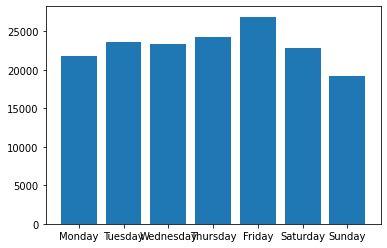

In [9]:
plt.bar(weekdays.index, weekdays.values)
plt.show()

The clearest takeaways seem to be that Friday is particularly dangerous and Sunday is relatively safe.

# Time of Day

In [10]:
hourly.LocalTime = pd.to_datetime(hourly['LocalTime'])

In [11]:
hourly['hour'] = hourly.LocalTime.dt.hour
hourly['month'] = hourly.LocalTime.dt.month
hourly['year'] = hourly.LocalTime.dt.year

In [12]:
crashtime = hourly.groupby('hour')['count'].sum()

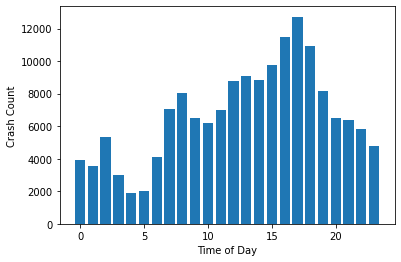

In [14]:
plt.bar(crashtime.index, crashtime.values)
plt.xlabel('Time of Day')
plt.ylabel('Crash Count')
plt.show()

The distribution seems logical. Some crashes occur before work, then a lull, slight pickup during lunch, and then the 
most occur during evening rush hour.

Although it stands to reason that this pattern wouldnt hold at all during the weekend.

In [15]:
wk= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
wkend= ['Saturday', 'Sunday']
crashtimeweekday = hourly[hourly['Weekday'].isin(wk)].groupby('hour')['count'].sum()
crashtimeweekend = hourly[hourly['Weekday'].isin(wkend)].groupby('hour')['count'].sum()

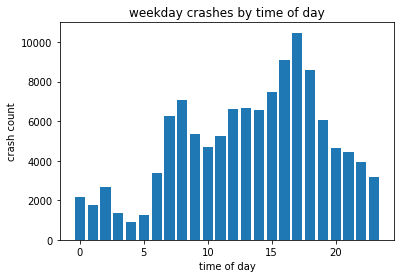

In [18]:
plt.bar(crashtimeweekday.index, crashtimeweekday.values)
plt.xlabel('time of day')
plt.ylabel('crash count')
plt.title('weekday crashes by time of day')
plt.show()

When the weekdays are isolated, the pattern appears to be even more pronounced.

Now to check the weekends:

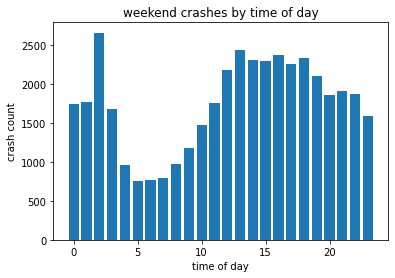

In [17]:
plt.bar(crashtimeweekend.index, crashtimeweekend.values)
plt.xlabel('time of day')
plt.ylabel('crash count')
plt.title('weekend crashes by time of day')
plt.show()

A substantially different distribution from weekdays, but logical nonetheless. Austin bars close at 2AM which accounts
for the huge spike between 2-3. Then the rest of the day appears to be related to when people are awake/most active.

# Crashes by Month

In [19]:
#defining a function to add a horizontal line representing yearly average to the following plots.
yearly_avg = hourly.groupby('year')['count'].mean()
def avg_line(col, xmin, xmax,color=0):
    return plt.hlines(yearly_avg[col],xmin,xmax)

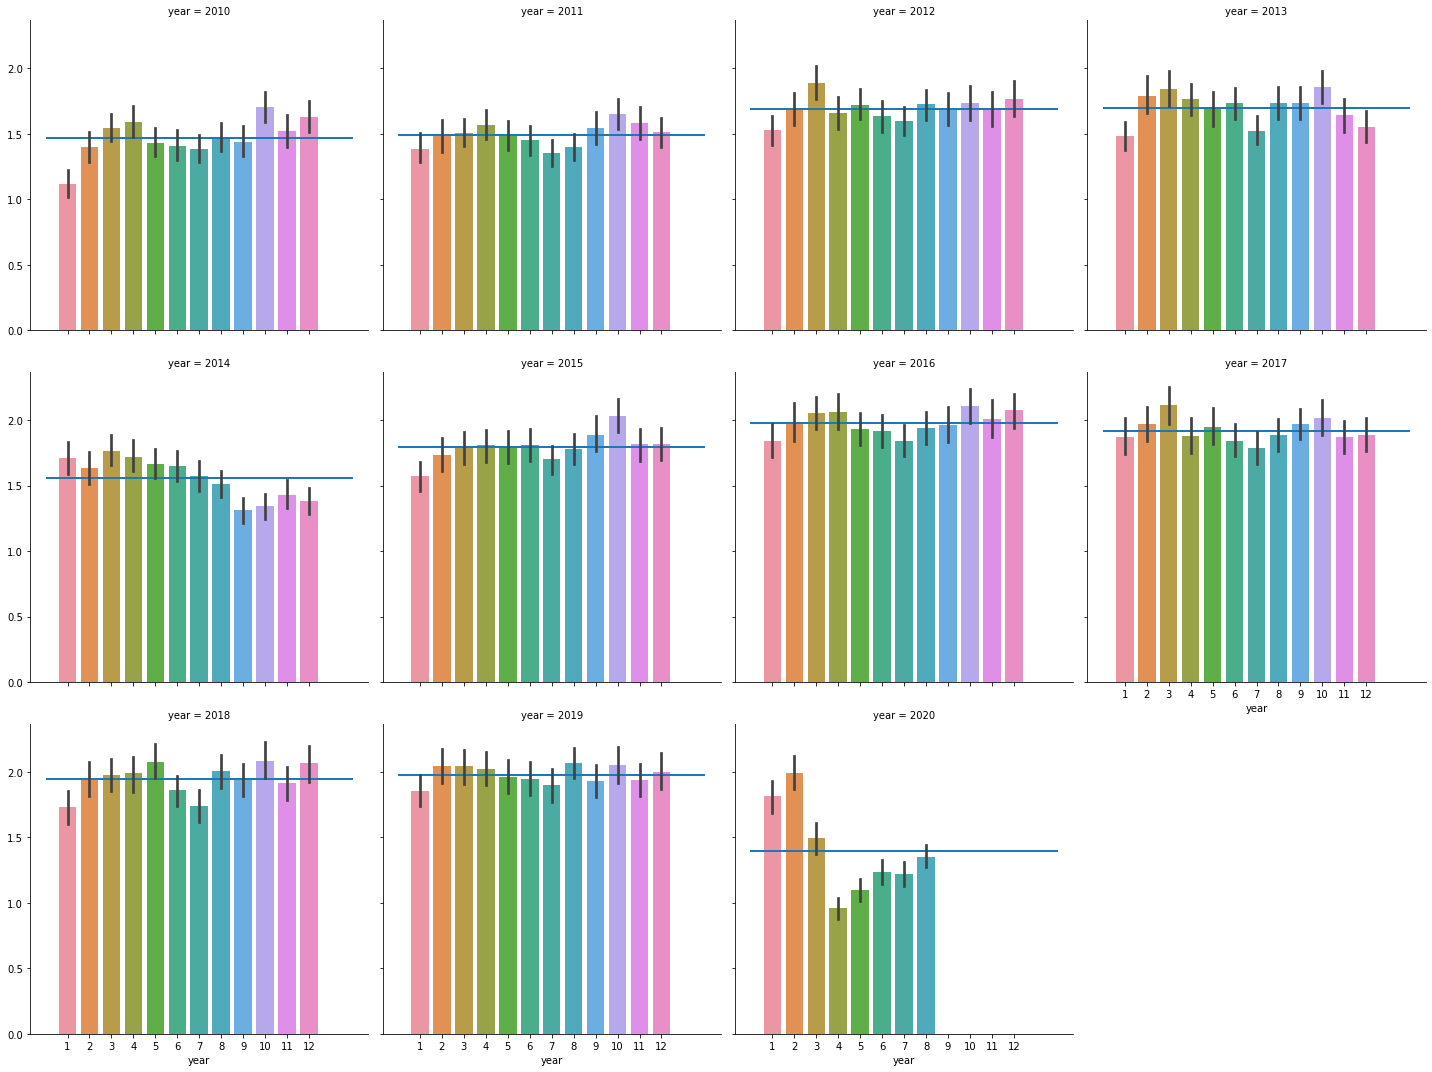

In [20]:
g = sns.catplot(x="month", y="count", col="year", data=hourly, kind="bar", col_wrap=4)
g.map(avg_line,'year',xmin=-1,xmax=13)
plt.show()

There does appear to be some patterns. Dips in crashes per day during January/June/July (possibly because they start
with 'J'?) and October is consistenly above average. However, the variance in yearly average and monthly patterns
with a sample size of ten years might make it challenging to draw useful conclusions from these distributions.

What is clear however is that 2020 is no normal year. Would be useful to have a column designating whether
the observations occured during a pandemic or not...

In [21]:
hourly['pandemic'] = (hourly['month'].isin([3,4,5,6,7,8])) & (hourly['year']==2020)

In [22]:
hourly['pandemic'].value_counts()

False    89088
True      4415
Name: pandemic, dtype: int64

# The Effect of Rain

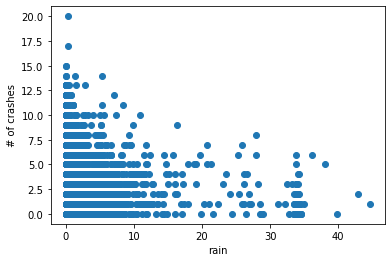

In [24]:
plt.scatter(hourly['rain_1h'], hourly['count'])
plt.xlabel('rain')
plt.ylabel('# of crashes')
plt.show()

Without accounting for other factors, it's hard to decipher a linear relationship between amount of rain and number
of crashes. However, it may be useful to look at rain as a binary categorical variable (i.e. 'raining' or 'not raining').

In [26]:
hourly['raining'] = np.where(hourly['rain_1h'] > 0, 'yes', 'no')

Now I'd like to see if there is a visible difference in the distribution of average crashes throughout the day when it is raining and when it is not raining. I'll use all Fridays as an example:

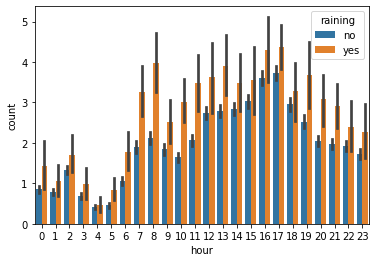

In [27]:
fridays= hourly[hourly['Weekday']=='Friday']
sns.barplot(x='hour',y='count',hue='raining', data=fridays)
plt.show()

While the confidence intervals overlap on occasion, there does appear to be a consistent increase in crahses when it is raining. Now for the other days of the week:

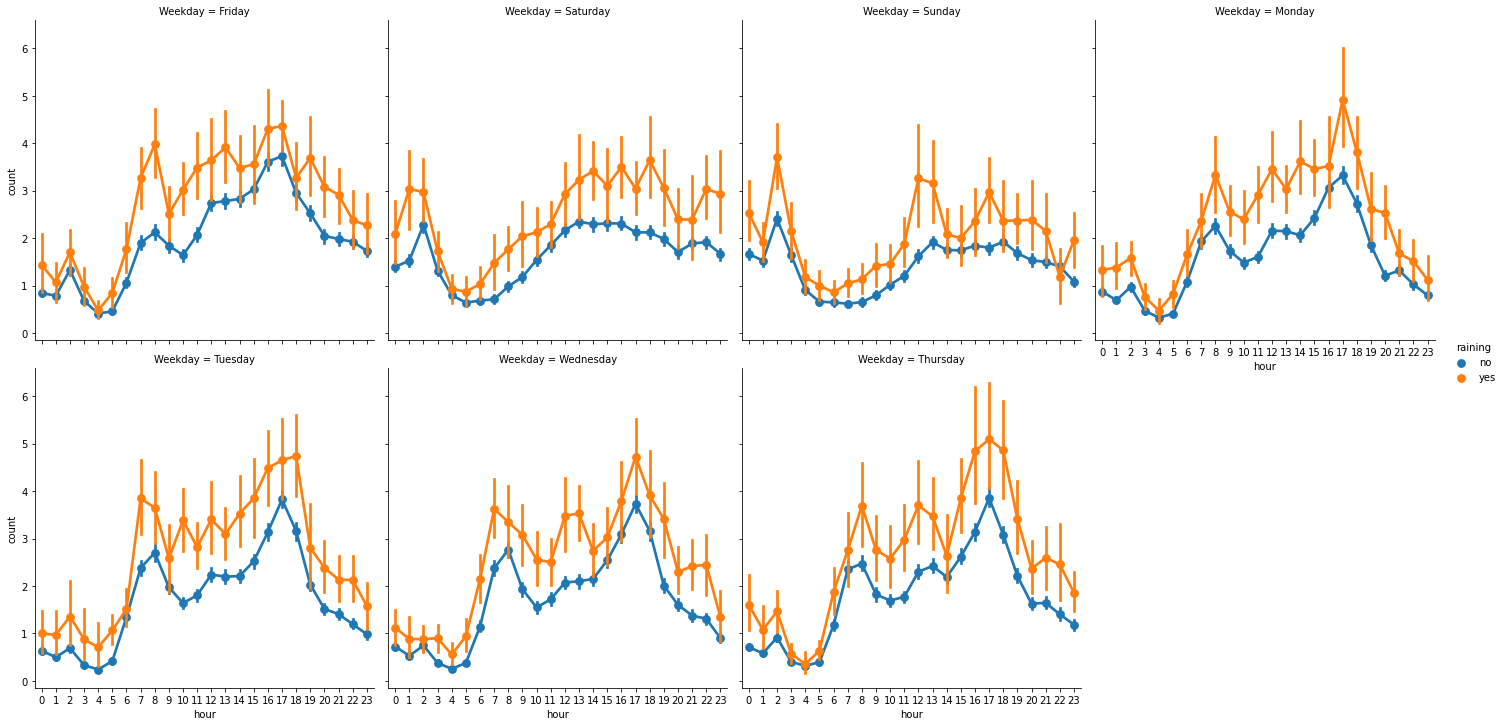

In [28]:
wkline = sns.catplot(x="hour",y='count', col="Weekday", data=hourly, kind="point", col_wrap=4,hue='raining')
plt.show()

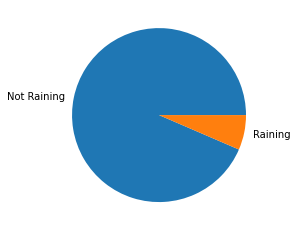

In [38]:
plt.pie(hourly['raining'].value_counts(normalize=True),labels=['Not Raining','Raining'])
plt.show()

Even more clear now.

Also, clear dichotomy between weekday and weekend patterns is even more apparent.

Even though rain's effect is clear in the visulizations, it is probably worthwile to perform a difference of means test to see how likely this difference would occur by means of chance since there is a relatively small sample size of observations that occured while raining.

In [33]:
raining_mean_crashes = hourly[hourly['raining']=='yes']['count'].mean()
dry_mean_crashes = hourly[hourly['raining']=='no']['count'].mean()
print(raining_mean_crashes, dry_mean_crashes)

2.4597985801551925 1.6801797680854471


In [34]:
def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

total_mean = hourly['count'].mean()

raining_shifted = hourly[hourly['raining']=='yes']['count'] - raining_mean_crashes + total_mean
dry_shifted = hourly[hourly['raining']=='no']['count'] - dry_mean_crashes + total_mean

In [35]:
emp_diff = raining_mean_crashes - dry_mean_crashes
rain_reps = draw_bs_reps(raining_shifted, np.mean, 10000)
dry_reps = draw_bs_reps(dry_shifted, np.mean, 10000)
diff_reps = rain_reps - dry_reps

In [37]:
p_value = sum(diff_reps >= emp_diff)/len(diff_reps)
print('p value:'+str(p_value))

p value:0.0


Very low p-value. Pretty clear indicator of a true difference in means when raining.

# The Pandemic Effect

When creating the predictive model, it will probably be at least worth considering dropping data after March 2020

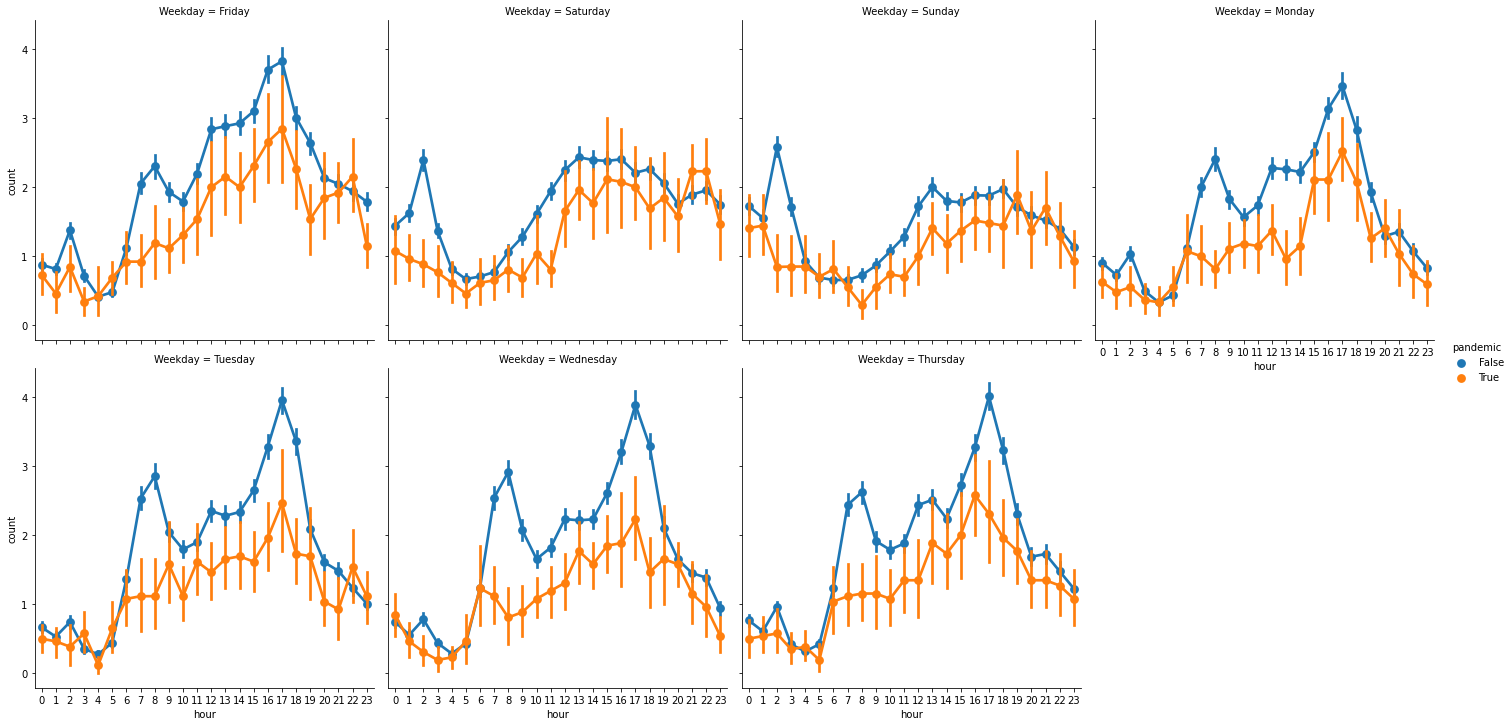

In [39]:
sns.catplot(x="hour",y='count', col="Weekday", data=hourly, kind="point", col_wrap=4,hue='pandemic')
plt.show()

While the same patterns exist to an extent, they are much less consistent/pronounced during the past few months. I will likely only use non-pandemic data in the model and hope that it will be another 100 years until the pandemic data is relevant again.

# Quick Check on Other Weather Variables

In [40]:
#first, I will isolate weather's effect by subsetting to all data from 5PM on Fridays.
friday_at_5 = fridays[fridays.hour == 5]

In [41]:
#next, drop non-continuous data from this set.
non_weather = ['city_name', 'raining', 'hour', 'month', 'year','Weekday','LocalTime','lat','lon','timezone','utc_unix']
friday_at_5 = friday_at_5.drop(non_weather, axis=1)

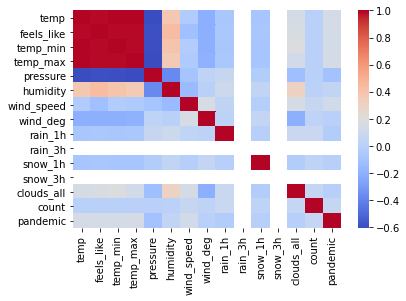

In [42]:
#finally the heatmap
sns.heatmap(friday_at_5.corr(),cmap='coolwarm')
plt.show()

Nothing too surprising here.

# Conclusion

There are definitely clear patterns if not simple linear relationships. Most of the useful explanatory variables in this set are discrete/categorical. Will likely build a Decision Tree or Random Forest predictive model.